# GEDI_L4B Search and Visualize

Authors: Nikita Susan (UAH), Aimee Barciauskas (DevSeed), Sumant Jha (MSFC/USRA), Alex Mandel (DevSeed)

Date: April 7, 2023

Description: In this example, we demonstrate how to access the GEDI L4B collection and granule data on the MAAP ADE, and then visualize the data using matplotlib.

## Run This Notebook
To access and run this tutorial within MAAP's Algorithm Development Environment (ADE), please refer to the ["Getting started with the MAAP"](https://docs.maap-project.org/en/latest/getting_started/getting_started.html) section of our documentation.

Disclaimer: it is highly recommended to run a tutorial within MAAP's ADE, which already includes packages specific to MAAP, such as maap-py. Running the tutorial outside of the MAAP ADE may lead to errors.

## About the Data

GEDI L4B Gridded Aboveground Biomass Density, Version 2

This dataset provides Global Ecosystem Dynamics Investigation (GEDI) Level 4 (L4) data, which has the purpose of providing mean aboveground biomass density (AGBD) and consists of the GEDI_L4A and GEDI_L4B collections. GEDI_L4B uses a sample present within each 1km cell to statistically infer mean AGBD. GEDI is attached to the International Space Station (ISS) and collects data globally between 51.6° N and 51.6° S latitudes at the highest resolution and densest sampling of any light detection and ranging (lidar) instrument in orbit to date; specifically, GEDI L4B data has a spatial resolution of 1km. (Source: [GEDI_L4B Version 2 User Guide](https://daac.ornl.gov/GEDI/guides/GEDI_L4B_Gridded_Biomass.html))

## Additional Resources
- [GEDI_L4B Version 2 Dataset Landing Page](https://daac.ornl.gov/cgi-bin/dsviewer.pl?ds_id=2017) 
- [The GEDI Website](https://gedi.umd.edu/)
- [Earthdata Search](https://search.earthdata.nasa.gov/search?q=GEDI_L4B&lat=49.70652984841501&long=-102.041015625&zoom=6)

## Importing Packages

Within your Jupyter Notebook, start by importing the **maap package**. Then invoke the **MAAP** constructor, setting the maap_host argument to **'api.maap-project.org'**.

In [22]:
from maap.maap import MAAP
from matplotlib import pyplot
import os
import pprint
import rasterio
import boto3

maap = MAAP(maap_host="api.maap-project.org")

## Search for the Collection and Associated Granules

Now, we will search for the collection using the collection short name:

In [23]:
collection = maap.searchCollection(cmr_host='cmr.earthdata.nasa.gov', short_name="GEDI_L4B_Gridded_Biomass_2017", limit=100)
print(collection)

[{'concept-id': 'C2244602422-ORNL_CLOUD', 'revision-id': '7', 'format': 'application/echo10+xml', 'Collection': {'ShortName': 'GEDI_L4B_Gridded_Biomass_2017', 'VersionId': '2', 'InsertTime': '2022-03-29T00:00:00Z', 'LastUpdate': '2023-06-12T20:25:17Z', 'LongName': 'GEDI L4B Gridded Aboveground Biomass Density, Version 2', 'DataSetId': 'GEDI L4B Gridded Aboveground Biomass Density, Version 2', 'Description': "This Global Ecosystem Dynamics Investigation (GEDI) L4B product provides 1 km x 1 km (1 km,  hereafter) estimates of mean aboveground biomass density (AGBD) based on observations from mission week 19 starting on 2019-04-18 to mission week 138 ending on 2021-08-04. The GEDI L4A Footprint Biomass product converts each high-quality waveform to an AGBD prediction, and the L4B product uses the sample present within the borders of each 1 km cell to statistically infer mean AGBD. The gridding procedure is described in the GEDI L4B Algorithm Theoretical Basis Document (ATBD). Patterson et 

Next, we can search for granules using the searchGranule function and the concept ID from our collection search above:

In [24]:
COLLECTIONID = collection[0]['concept-id']
results = maap.searchGranule(cmr_host='cmr.earthdata.nasa.gov',concept_id=COLLECTIONID)  # COLLECTIONID 'C2244602422-ORNL_CLOUD'
print(f'Got {len(results)} results')
results[0]['Granule']

Got 10 results


{'GranuleUR': 'GEDI_L4B_Gridded_Biomass.GEDI04_B_MW019MW138_02_002_05_R01000M_PS.tif',
 'InsertTime': '2022-03-29T00:00:00Z',
 'LastUpdate': '2023-04-10T21:58:24Z',
 'Collection': {'ShortName': 'GEDI_L4B_Gridded_Biomass_2017',
  'VersionId': '2'},
 'DataGranule': {'DataGranuleSizeInBytes': '20103343',
  'SizeMBDataGranule': '20.103343',
  'Checksum': {'Value': '025a141348906d5e612262218c496a2d468446ca30875439be6651d851bfbe23',
   'Algorithm': 'SHA-256'},
  'DayNightFlag': 'BOTH',
  'ProductionDateTime': '2022-03-29T00:00:00Z'},
 'Temporal': {'RangeDateTime': {'BeginningDateTime': '2019-04-18T00:00:00Z',
   'EndingDateTime': '2021-08-04T23:59:59Z'}},
 'Spatial': {'HorizontalSpatialDomain': {'Geometry': {'BoundingRectangle': {'WestBoundingCoordinate': '-180',
     'NorthBoundingCoordinate': '52',
     'EastBoundingCoordinate': '180',
     'SouthBoundingCoordinate': '-52'}}}},
 'MeasuredParameters': {'MeasuredParameter': [{'ParameterName': 'LIDAR WAVEFORM'},
   {'ParameterName': 'BIOMASS'

## Accessing and Downloading the Granule from ORNL DAAC S3

Before downloading, we'll get the collection and file name:

In [25]:
granule_ur=results[0]['Granule']['GranuleUR'].split(".")
collection_name=granule_ur[0]
file_name=granule_ur[1]

print(collection_name)
print(file_name)

GEDI_L4B_Gridded_Biomass
GEDI04_B_MW019MW138_02_002_05_R01000M_PS


Now we'll proceed to get tempory s3 credentials, and then download the tif file to our workspace:

In [26]:
def get_s3_creds(url):
    return maap.aws.earthdata_s3_credentials(url)

def get_s3_client(s3_cred_endpoint):
    creds=get_s3_creds(s3_cred_endpoint)
    boto3_session = boto3.Session(
            aws_access_key_id=creds['accessKeyId'],
            aws_secret_access_key=creds['secretAccessKey'],
            aws_session_token=creds['sessionToken']
    )
    return boto3_session.client("s3")

def download_s3_file(s3, bucket, collection_name, file_name):
    os.makedirs("/projects/gedi_l4b", exist_ok=True) # create directories, as necessary
    download_path=f"/projects/gedi_l4b/{file_name}.tif"
    s3.download_file(bucket, f"gedi/{collection_name}/data/{file_name}.tif", download_path)
    return download_path

In [27]:
s3_cred_endpoint= 'https://data.ornldaac.earthdata.nasa.gov/s3credentials'
s3=get_s3_client(s3_cred_endpoint)

In [28]:
bucket="ornl-cumulus-prod-protected"
download_path=download_s3_file(s3, bucket, collection_name, file_name)
download_path

'/projects/gedi_l4b/GEDI04_B_MW019MW138_02_002_05_R01000M_PS.tif'

Open the local file using rasterio, and print the shape of the data to verify if the file was read properly:

In [29]:
src = rasterio.open(download_path)
data = src.read(1)

print(data.shape) 

(14616, 34704)


## Plot the Data

Finally, we'll use matplotlib to visualize our .tif file:

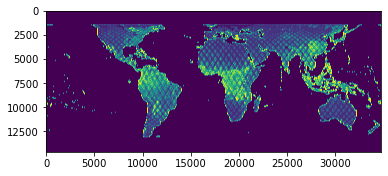

In [30]:
pyplot.imshow(data)
pyplot.show()